In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          12352     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5237 - acc: 0.1979
Epoch 00001: val_loss improved from inf to 2.40919, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/001-2.4092.hdf5
36805/36805 [==============================] - 29s 794us/sample - loss: 2.5236 - acc: 0.1979 - val_loss: 2.4092 - val_acc: 0.2197
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1779 - acc: 0.3385
Epoch 00002: val_loss improved from 2.40919 to 2.36781, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/002-2.3678.hdf5
36805/36805 [==============================] - 27s 747us/sample - loss: 2.1776 - acc: 0.3385 - val_loss: 2.3678 - val_acc: 0.2527
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9278 - acc: 0.4285
Epoch 00003: val_loss did not improve from 2.36781
36805/36805 [=

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9613
Epoch 00029: val_loss did not improve from 2.36781
36805/36805 [==============================] - 26s 713us/sample - loss: 0.2136 - acc: 0.9612 - val_loss: 4.1367 - val_acc: 0.2583
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2074 - acc: 0.9618
Epoch 00030: val_loss did not improve from 2.36781
36805/36805 [==============================] - 26s 716us/sample - loss: 0.2075 - acc: 0.9618 - val_loss: 4.2009 - val_acc: 0.2485
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1962 - acc: 0.9652
Epoch 00031: val_loss did not improve from 2.36781
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1962 - acc: 0.9652 - val_loss: 4.2956 - val_acc: 0.2579
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1791 - acc: 0.9696
Epoch 00032: val_loss did not improve from 2.36781
36805/36805 [=====

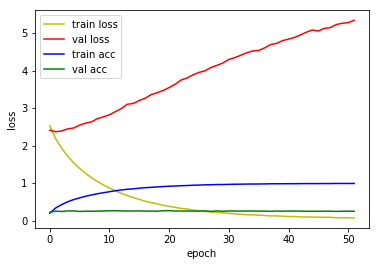

4815/4815 [==============================] - 2s 315us/sample - loss: 2.3844 - acc: 0.2478
Loss: 2.384440688651175 Accuracy: 0.24776739

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3191 - acc: 0.2759
Epoch 00001: val_loss improved from inf to 2.10270, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/001-2.1027.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.3190 - acc: 0.2759 - val_loss: 2.1027 - val_acc: 0.3739
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9327 - acc: 0.4193
Epoch 00002: val_loss improved from 2.10270 to 1.95982, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/002-1.9598.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9326 - acc: 0.4194 - val_loss: 1.9598 - val_acc: 0.3951
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9712
Epoch 00029: val_loss did not improve from 1.91188
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1289 - acc: 0.9713 - val_loss: 3.5659 - val_acc: 0.4072
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9746
Epoch 00030: val_loss did not improve from 1.91188
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1160 - acc: 0.9747 - val_loss: 3.6497 - val_acc: 0.4062
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1142 - acc: 0.9753
Epoch 00031: val_loss did not improve from 1.91188
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1141 - acc: 0.9753 - val_loss: 3.7266 - val_acc: 0.4020
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9787
Epoch 00032: val_loss did not improve from 1.91188
36805/36805 [========================

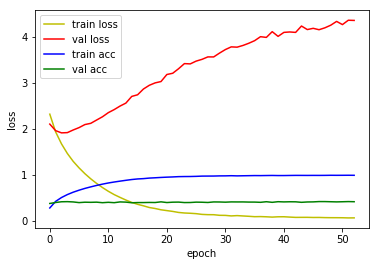

4815/4815 [==============================] - 2s 426us/sample - loss: 1.9535 - acc: 0.3801
Loss: 1.953531569186772 Accuracy: 0.3800623

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2804 - acc: 0.2874
Epoch 00001: val_loss improved from inf to 1.98029, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/001-1.9803.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.2804 - acc: 0.2874 - val_loss: 1.9803 - val_acc: 0.4246
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8092 - acc: 0.4506
Epoch 00002: val_loss improved from 1.98029 to 1.76400, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/002-1.7640.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.8092 - acc: 0.4506 - val_loss: 1.7640 - val_acc: 0.4612
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2742 - acc: 0.9169
Epoch 00028: val_loss did not improve from 1.64049
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2742 - acc: 0.9169 - val_loss: 2.0871 - val_acc: 0.5497
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2610 - acc: 0.9210
Epoch 00029: val_loss did not improve from 1.64049
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2610 - acc: 0.9210 - val_loss: 2.1425 - val_acc: 0.5434
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2489 - acc: 0.9250
Epoch 00030: val_loss did not improve from 1.64049
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2489 - acc: 0.9250 - val_loss: 2.1241 - val_acc: 0.5565
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2352 - acc: 0.9297
Epoch 00031: val_loss did not improve from 1.64049
36805/36805 [===========

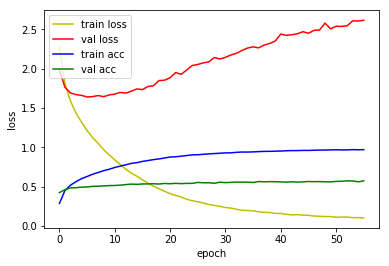

4815/4815 [==============================] - 2s 490us/sample - loss: 1.7023 - acc: 0.4800
Loss: 1.7022625235877429 Accuracy: 0.47995847

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2652 - acc: 0.2814
Epoch 00001: val_loss improved from inf to 1.80609, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/001-1.8061.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.2650 - acc: 0.2815 - val_loss: 1.8061 - val_acc: 0.4277
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6672 - acc: 0.4743
Epoch 00002: val_loss improved from 1.80609 to 1.55488, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/002-1.5549.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6672 - acc: 0.4743 - val_loss: 1.5549 - val_acc: 0.5234
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9533
Epoch 00056: val_loss did not improve from 1.15065
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1445 - acc: 0.9533 - val_loss: 1.5423 - val_acc: 0.6904
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1410 - acc: 0.9565
Epoch 00057: val_loss did not improve from 1.15065
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1410 - acc: 0.9565 - val_loss: 1.5106 - val_acc: 0.6907
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1408 - acc: 0.9561
Epoch 00058: val_loss did not improve from 1.15065
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1408 - acc: 0.9561 - val_loss: 1.4887 - val_acc: 0.6972
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1351 - acc: 0.9572
Epoch 00059: val_loss did not improve from 1.15065
36805/36805 [===========

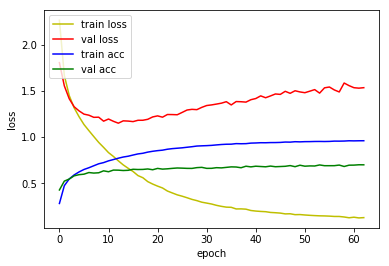

4815/4815 [==============================] - 3s 527us/sample - loss: 1.2722 - acc: 0.6152
Loss: 1.2722239464119092 Accuracy: 0.61516094

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2555 - acc: 0.2697
Epoch 00001: val_loss improved from inf to 1.67399, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/001-1.6740.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.2554 - acc: 0.2698 - val_loss: 1.6740 - val_acc: 0.4675
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5781 - acc: 0.4996
Epoch 00002: val_loss improved from 1.67399 to 1.39646, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/002-1.3965.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.5780 - acc: 0.4996 - val_loss: 1.3965 - val_acc: 0.5646
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1527 - acc: 0.9498
Epoch 00055: val_loss did not improve from 0.89955
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1527 - acc: 0.9498 - val_loss: 1.1606 - val_acc: 0.7522
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1460 - acc: 0.9505
Epoch 00056: val_loss did not improve from 0.89955
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1460 - acc: 0.9505 - val_loss: 1.2002 - val_acc: 0.7519
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1422 - acc: 0.9537
Epoch 00057: val_loss did not improve from 0.89955
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1422 - acc: 0.9537 - val_loss: 1.0984 - val_acc: 0.7545
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9530
Epoch 00058: val_loss did not improve from 0.89955
36805/36805 [===========

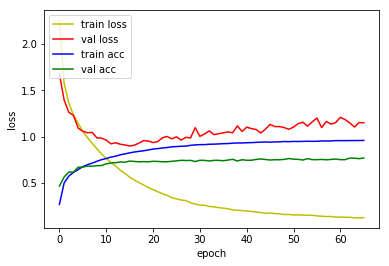

4815/4815 [==============================] - 3s 548us/sample - loss: 1.0125 - acc: 0.7030
Loss: 1.0124600182317376 Accuracy: 0.7030114

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3507 - acc: 0.2362
Epoch 00001: val_loss improved from inf to 1.83281, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/001-1.8328.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.3505 - acc: 0.2364 - val_loss: 1.8328 - val_acc: 0.3972
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6527 - acc: 0.4651
Epoch 00002: val_loss improved from 1.83281 to 1.43185, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/002-1.4318.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.6527 - acc: 0.4651 - val_loss: 1.4318 - val_acc: 0.5500
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5276 - acc: 0.8425
Epoch 00024: val_loss improved from 0.59677 to 0.58169, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/024-0.5817.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5275 - acc: 0.8425 - val_loss: 0.5817 - val_acc: 0.8383
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5101 - acc: 0.8458
Epoch 00025: val_loss did not improve from 0.58169
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5100 - acc: 0.8458 - val_loss: 0.6026 - val_acc: 0.8293
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4910 - acc: 0.8527
Epoch 00026: val_loss improved from 0.58169 to 0.57252, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/026-0.5725.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4910 - acc: 0.8527 - val_loss: 0.572

36800/36805 [============================>.] - ETA: 0s - loss: 0.1568 - acc: 0.9485
Epoch 00080: val_loss did not improve from 0.49802
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1568 - acc: 0.9485 - val_loss: 0.5361 - val_acc: 0.8751
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9466
Epoch 00081: val_loss did not improve from 0.49802
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1588 - acc: 0.9466 - val_loss: 0.5364 - val_acc: 0.8763
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1582 - acc: 0.9475
Epoch 00082: val_loss did not improve from 0.49802
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1582 - acc: 0.9475 - val_loss: 0.5676 - val_acc: 0.8758
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9470
Epoch 00083: val_loss did not improve from 0.49802
36805/36805 [========================

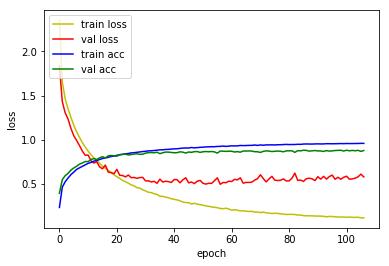

4815/4815 [==============================] - 3s 549us/sample - loss: 0.6240 - acc: 0.8378
Loss: 0.624022770546926 Accuracy: 0.83779854

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3327 - acc: 0.2297
Epoch 00001: val_loss improved from inf to 1.75795, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/001-1.7579.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.3327 - acc: 0.2296 - val_loss: 1.7579 - val_acc: 0.4645
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7246 - acc: 0.4315
Epoch 00002: val_loss improved from 1.75795 to 1.44417, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/002-1.4442.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7248 - acc: 0.4314 - val_loss: 1.4442 - val_acc: 0.5423
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

36800/36805 [============================>.] - ETA: 0s - loss: 0.2444 - acc: 0.9218
Epoch 00049: val_loss did not improve from 0.26911
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2445 - acc: 0.9218 - val_loss: 0.2692 - val_acc: 0.9231
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2403 - acc: 0.9231
Epoch 00050: val_loss did not improve from 0.26911
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2403 - acc: 0.9231 - val_loss: 0.2774 - val_acc: 0.9224
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2348 - acc: 0.9250
Epoch 00051: val_loss improved from 0.26911 to 0.25186, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/051-0.2519.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2348 - acc: 0.9250 - val_loss: 0.2519 - val_acc: 0.9299
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2298 - acc:

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9454
Epoch 00078: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1645 - acc: 0.9453 - val_loss: 0.2532 - val_acc: 0.9364
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1647 - acc: 0.9457
Epoch 00079: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1646 - acc: 0.9457 - val_loss: 0.2451 - val_acc: 0.9366
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9473
Epoch 00080: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1587 - acc: 0.9473 - val_loss: 0.2659 - val_acc: 0.9348
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9475
Epoch 00081: val_loss did not improve from 0.23765
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9607
Epoch 00108: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1145 - acc: 0.9606 - val_loss: 0.2751 - val_acc: 0.9357
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9607
Epoch 00109: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1154 - acc: 0.9607 - val_loss: 0.2575 - val_acc: 0.9411
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1092 - acc: 0.9629
Epoch 00110: val_loss did not improve from 0.23765
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1093 - acc: 0.9629 - val_loss: 0.2638 - val_acc: 0.9429
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1143 - acc: 0.9607
Epoch 00111: val_loss did not improve from 0.23765
36805/36805 [=======

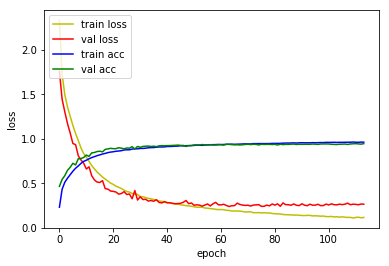

4815/4815 [==============================] - 3s 592us/sample - loss: 0.2926 - acc: 0.9132
Loss: 0.29255701827111646 Accuracy: 0.913188

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4227 - acc: 0.2031
Epoch 00001: val_loss improved from inf to 1.68649, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/001-1.6865.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.4226 - acc: 0.2032 - val_loss: 1.6865 - val_acc: 0.4773
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6421 - acc: 0.4585
Epoch 00002: val_loss improved from 1.68649 to 1.24191, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/002-1.2419.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6422 - acc: 0.4584 - val_loss: 1.2419 - val_acc: 0.6161
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3483 - acc: 0.8907
Epoch 00024: val_loss improved from 0.25811 to 0.24222, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/024-0.2422.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3483 - acc: 0.8907 - val_loss: 0.2422 - val_acc: 0.9266
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.8925
Epoch 00025: val_loss improved from 0.24222 to 0.23611, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/025-0.2361.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3381 - acc: 0.8925 - val_loss: 0.2361 - val_acc: 0.9297
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3277 - acc: 0.8948
Epoch 00026: val_loss improved from 0.23611 to 0.22487, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/026-0.2249.hdf5
36805/36805 

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9576
Epoch 00079: val_loss did not improve from 0.15251
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1255 - acc: 0.9576 - val_loss: 0.1580 - val_acc: 0.9576
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9594
Epoch 00080: val_loss did not improve from 0.15251
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1188 - acc: 0.9594 - val_loss: 0.1696 - val_acc: 0.9550
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1141 - acc: 0.9619
Epoch 00081: val_loss did not improve from 0.15251
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1142 - acc: 0.9619 - val_loss: 0.1531 - val_acc: 0.9597
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9611
Epoch 00082: val_loss did not improve from 0.15251
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9727
Epoch 00108: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0810 - acc: 0.9727 - val_loss: 0.1579 - val_acc: 0.9590
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0825 - acc: 0.9720
Epoch 00109: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0825 - acc: 0.9720 - val_loss: 0.1627 - val_acc: 0.9611
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0791 - acc: 0.9740
Epoch 00110: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0791 - acc: 0.9740 - val_loss: 0.1822 - val_acc: 0.9592
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0832 - acc: 0.9712
Epoch 00111: val_loss did not improve from 0.14812
36805/36805 [=======

Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9786
Epoch 00138: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0640 - acc: 0.9786 - val_loss: 0.1679 - val_acc: 0.9611
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9774
Epoch 00139: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0641 - acc: 0.9774 - val_loss: 0.1795 - val_acc: 0.9567
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9797
Epoch 00140: val_loss did not improve from 0.14812
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0595 - acc: 0.9797 - val_loss: 0.1749 - val_acc: 0.9595
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9807
Epoch 00141: val_loss did not improve from 0.14812
36805/36805 [=======

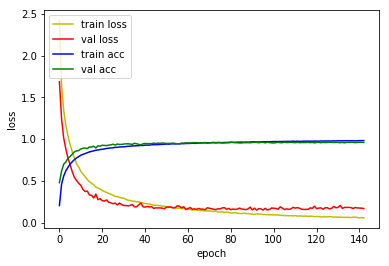

4815/4815 [==============================] - 3s 603us/sample - loss: 0.2126 - acc: 0.9375
Loss: 0.2125699835464838 Accuracy: 0.937487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2500 - acc: 0.2718
Epoch 00001: val_loss improved from inf to 1.37001, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/001-1.3700.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.2499 - acc: 0.2719 - val_loss: 1.3700 - val_acc: 0.5709
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2715 - acc: 0.5842
Epoch 00002: val_loss improved from 1.37001 to 0.91553, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/002-0.9155.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.2715 - acc: 0.5842 - val_loss: 0.9155 - val_acc: 0.7144
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9312
Epoch 00024: val_loss did not improve from 0.19759
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2105 - acc: 0.9312 - val_loss: 0.2018 - val_acc: 0.9387
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2001 - acc: 0.9352
Epoch 00025: val_loss did not improve from 0.19759
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2001 - acc: 0.9351 - val_loss: 0.2062 - val_acc: 0.9397
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2040 - acc: 0.9352
Epoch 00026: val_loss improved from 0.19759 to 0.18146, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/026-0.1815.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2040 - acc: 0.9352 - val_loss: 0.1815 - val_acc: 0.9457
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9689
Epoch 00052: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0892 - acc: 0.9689 - val_loss: 0.1977 - val_acc: 0.9474
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9690
Epoch 00053: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0891 - acc: 0.9690 - val_loss: 0.1856 - val_acc: 0.9522
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9692
Epoch 00054: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0895 - acc: 0.9692 - val_loss: 0.1857 - val_acc: 0.9511
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9705
Epoch 00055: val_loss did not improve from 0.16848
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9828
Epoch 00082: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0514 - acc: 0.9828 - val_loss: 0.2157 - val_acc: 0.9515
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9836
Epoch 00083: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0498 - acc: 0.9836 - val_loss: 0.2017 - val_acc: 0.9555
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9839
Epoch 00084: val_loss did not improve from 0.16848
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0462 - acc: 0.9839 - val_loss: 0.1934 - val_acc: 0.9541
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9853
Epoch 00085: val_loss did not improve from 0.16848
36805/36805 [===========

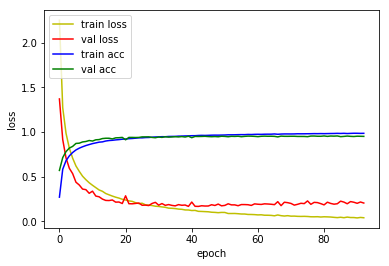

4815/4815 [==============================] - 3s 628us/sample - loss: 0.2076 - acc: 0.9406
Loss: 0.2075623875590252 Accuracy: 0.9406023



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 395us/sample - loss: 2.3844 - acc: 0.2478
Loss: 2.384440688651175 Accuracy: 0.24776739

1D_CNN_2_conv_custom_conv_3_DO Model
___________________________________________________

4815/4815 [==============================] - 3s 653us/sample - loss: 0.6240 - acc: 0.8378
Loss: 0.624022770546926 Accuracy: 0.83779854

1D_CNN_7_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None,

4815/4815 [==============================] - 3s 674us/sample - loss: 0.2076 - acc: 0.9406
Loss: 0.2075623875590252 Accuracy: 0.9406023


In [12]:
def build_1d_cnn_custom_conv_3_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [13]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense_18 (Dense)             (None, 16)                16384016  
Total params: 20,480,528
Trainable params: 18,432,400
Non-trainable params: 2,048,128
________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.9326 - acc: 0.2021
Epoch 00001: val_loss improved from inf to 12.68151, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_BN_checkpoint/001-12.6815.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 11.9332 - acc: 0.2020 - val_loss: 12.6815 - val_acc: 0.1700
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.1493 - acc: 0.2744
Epoch 00002: val_loss improved from 12.68151 to 11.63514, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_BN_checkpoint/002-11.6351.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 11.1495 - acc: 0.2744 - val_loss: 11.6351 - val_acc: 0.2381
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.6771 - acc: 0.3070
Epoch 00003: val_loss did not improve from 11.63514
36805/36805 [==============================] - 50s 1m

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.1904 - acc: 0.5434
Epoch 00029: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 7.1907 - acc: 0.5434 - val_loss: 11.4617 - val_acc: 0.2679
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.1527 - acc: 0.5469
Epoch 00030: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 7.1535 - acc: 0.5468 - val_loss: 11.5224 - val_acc: 0.2679
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.0614 - acc: 0.5520
Epoch 00031: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 7.0618 - acc: 0.5520 - val_loss: 12.0127 - val_acc: 0.2409
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.0316 - acc: 0.5529
Epoch 00032: val_loss did not improve from 11.34552
36805/36805 [====

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.9622 - acc: 0.6230
Epoch 00059: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 5.9618 - acc: 0.6231 - val_loss: 12.2114 - val_acc: 0.2318
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.9234 - acc: 0.6256
Epoch 00060: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 5.9239 - acc: 0.6256 - val_loss: 11.7484 - val_acc: 0.2581
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.8973 - acc: 0.6273
Epoch 00061: val_loss did not improve from 11.34552
36805/36805 [==============================] - 50s 1ms/sample - loss: 5.8969 - acc: 0.6273 - val_loss: 11.8711 - val_acc: 0.2504
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.8786 - acc: 0.6290
Epoch 00062: val_loss did not improve from 11.34552
36805/36805 [====

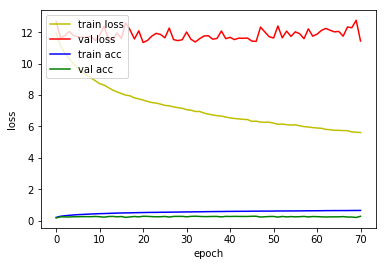

4815/4815 [==============================] - 3s 712us/sample - loss: 11.4560 - acc: 0.2710
Loss: 11.455967671799387 Accuracy: 0.27102804

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.2244 - acc: 0.2852
Epoch 00001: val_loss improved from inf to 4.67384, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_BN_checkpoint/001-4.6738.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 5.2254 - acc: 0.2852 - val_loss: 4.6738 - val_acc: 0.2642
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0513 - acc: 0.5348
Epoch 00002: val_loss did not improve from 4.67384
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.0515 - acc: 0.5348 - val_loss: 5.3691 - val_acc: 0.3270
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9266 - acc: 0.6865
Epoch 00003: val_loss did not improve from 4.67384
36805/36805 [===========

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3720 - acc: 0.9617
Epoch 00030: val_loss did not improve from 4.67384
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.3723 - acc: 0.9617 - val_loss: 8.4412 - val_acc: 0.3422
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3901 - acc: 0.9614
Epoch 00031: val_loss did not improve from 4.67384
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.3900 - acc: 0.9614 - val_loss: 8.7611 - val_acc: 0.3100
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3618 - acc: 0.9641
Epoch 00032: val_loss did not improve from 4.67384
36805/36805 [==============================] - 69s 2ms/sample - loss: 0.3617 - acc: 0.9641 - val_loss: 8.5946 - val_acc: 0.3452
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3565 - acc: 0.9647
Epoch 00033: val_loss did not improve from 4.67384
36805/36805 [===========

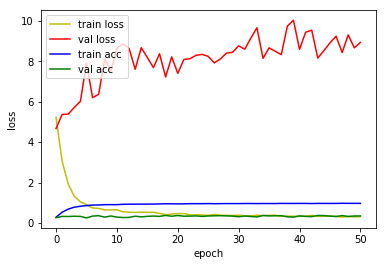

4815/4815 [==============================] - 4s 856us/sample - loss: 4.6505 - acc: 0.2548
Loss: 4.650502739962759 Accuracy: 0.25482866

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5471 - acc: 0.3885
Epoch 00001: val_loss improved from inf to 2.06086, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_BN_checkpoint/001-2.0609.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.5472 - acc: 0.3885 - val_loss: 2.0609 - val_acc: 0.4260
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1890 - acc: 0.6753
Epoch 00002: val_loss did not improve from 2.06086
36805/36805 [==============================] - 76s 2ms/sample - loss: 1.1892 - acc: 0.6753 - val_loss: 2.2511 - val_acc: 0.4775
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6136 - acc: 0.8301
Epoch 00003: val_loss did not improve from 2.06086
36805/36805 [=============

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9883
Epoch 00030: val_loss did not improve from 2.06086
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.0690 - acc: 0.9883 - val_loss: 4.9424 - val_acc: 0.4307
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9888
Epoch 00031: val_loss did not improve from 2.06086
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.0632 - acc: 0.9888 - val_loss: 4.1347 - val_acc: 0.4815
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9898
Epoch 00032: val_loss did not improve from 2.06086
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.0559 - acc: 0.9898 - val_loss: 4.1706 - val_acc: 0.4859
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9878
Epoch 00033: val_loss did not improve from 2.06086
36805/36805 [===========

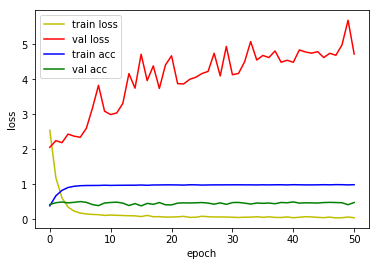

4815/4815 [==============================] - 5s 949us/sample - loss: 2.1746 - acc: 0.4046
Loss: 2.174618501603789 Accuracy: 0.40456906

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9281 - acc: 0.4422
Epoch 00001: val_loss improved from inf to 1.67024, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/001-1.6702.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 1.9281 - acc: 0.4422 - val_loss: 1.6702 - val_acc: 0.4731
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1702 - acc: 0.6502
Epoch 00002: val_loss improved from 1.67024 to 1.41029, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/002-1.4103.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 1.1705 - acc: 0.6502 - val_loss: 1.4103 - val_acc: 0.5938
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9917
Epoch 00029: val_loss did not improve from 1.35876
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0437 - acc: 0.9917 - val_loss: 2.0370 - val_acc: 0.6236
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9975
Epoch 00030: val_loss did not improve from 1.35876
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0217 - acc: 0.9975 - val_loss: 2.2405 - val_acc: 0.5982
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9973
Epoch 00031: val_loss did not improve from 1.35876
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0219 - acc: 0.9972 - val_loss: 2.0840 - val_acc: 0.6327
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9911
Epoch 00032: val_loss did not improve from 1.35876
36805/36805 [========================

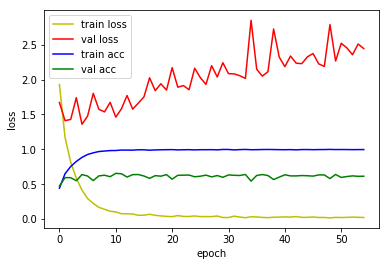

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.4996 - acc: 0.6077
Loss: 1.4996314696186182 Accuracy: 0.6076843

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7688 - acc: 0.4739
Epoch 00001: val_loss improved from inf to 1.59917, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/001-1.5992.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.7689 - acc: 0.4739 - val_loss: 1.5992 - val_acc: 0.5024
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1317 - acc: 0.6608
Epoch 00002: val_loss improved from 1.59917 to 1.24124, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/002-1.2412.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.1318 - acc: 0.6608 - val_loss: 1.2412 - val_acc: 0.6466
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9926
Epoch 00028: val_loss did not improve from 1.13631
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0434 - acc: 0.9926 - val_loss: 1.5981 - val_acc: 0.6823
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9924
Epoch 00029: val_loss did not improve from 1.13631
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0418 - acc: 0.9924 - val_loss: 1.4785 - val_acc: 0.7032
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9938
Epoch 00030: val_loss did not improve from 1.13631
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0360 - acc: 0.9938 - val_loss: 1.6560 - val_acc: 0.6792
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9905
Epoch 00031: val_loss did not improve from 1.13631
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9951
Epoch 00058: val_loss did not improve from 1.13631
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0241 - acc: 0.9951 - val_loss: 1.9540 - val_acc: 0.6709
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9970
Epoch 00059: val_loss did not improve from 1.13631
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0176 - acc: 0.9970 - val_loss: 1.7640 - val_acc: 0.6925

1D_CNN_5_conv_custom_conv_3_BN Model


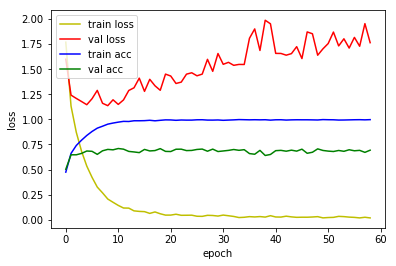

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.2151 - acc: 0.6739
Loss: 1.2150595301036895 Accuracy: 0.6739356

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7846 - acc: 0.4526
Epoch 00001: val_loss improved from inf to 1.50623, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/001-1.5062.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.7847 - acc: 0.4526 - val_loss: 1.5062 - val_acc: 0.5204
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1365 - acc: 0.6545
Epoch 00002: val_loss improved from 1.50623 to 1.05452, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/002-1.0545.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.1365 - acc: 0.6544 - val_loss: 1.0545 - val_acc: 0.6851
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9928
Epoch 00057: val_loss did not improve from 0.72457
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0374 - acc: 0.9928 - val_loss: 0.9008 - val_acc: 0.8064
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9915
Epoch 00058: val_loss did not improve from 0.72457
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0398 - acc: 0.9915 - val_loss: 0.9117 - val_acc: 0.7994
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.72457
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0273 - acc: 0.9957 - val_loss: 0.9302 - val_acc: 0.8027
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9971
Epoch 00060: val_loss did not improve from 0.72457
36805/36805 [===========

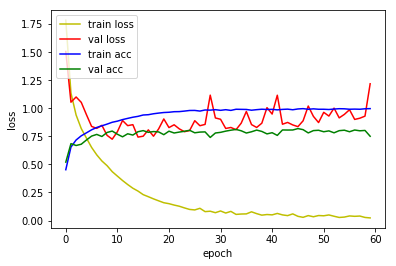

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.7999 - acc: 0.7624
Loss: 0.7998917551426873 Accuracy: 0.76240915

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8701 - acc: 0.4263
Epoch 00001: val_loss improved from inf to 1.60447, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/001-1.6045.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 1.8701 - acc: 0.4262 - val_loss: 1.6045 - val_acc: 0.4950
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1425 - acc: 0.6539
Epoch 00002: val_loss improved from 1.60447 to 1.06888, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/002-1.0689.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.1427 - acc: 0.6540 - val_loss: 1.0689 - val_acc: 0.6804
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9751
Epoch 00026: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1061 - acc: 0.9751 - val_loss: 0.4038 - val_acc: 0.8889
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9785
Epoch 00027: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0955 - acc: 0.9785 - val_loss: 0.4573 - val_acc: 0.8842
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9750
Epoch 00028: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1012 - acc: 0.9749 - val_loss: 0.4140 - val_acc: 0.8898
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9791
Epoch 00029: val_loss did not improve from 0.39365
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9927
Epoch 00056: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0350 - acc: 0.9927 - val_loss: 0.4186 - val_acc: 0.9022
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9928
Epoch 00057: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0337 - acc: 0.9927 - val_loss: 0.5660 - val_acc: 0.8724
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9879
Epoch 00058: val_loss did not improve from 0.39365
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0467 - acc: 0.9879 - val_loss: 0.4614 - val_acc: 0.8887
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9948
Epoch 00059: val_loss did not improve from 0.39365
36805/36805 [===========

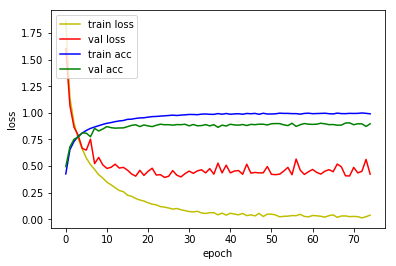

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4636 - acc: 0.8702
Loss: 0.46364169726119236 Accuracy: 0.8701973

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8483 - acc: 0.4415
Epoch 00001: val_loss improved from inf to 1.59272, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/001-1.5927.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 1.8483 - acc: 0.4415 - val_loss: 1.5927 - val_acc: 0.5022
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0000 - acc: 0.7058
Epoch 00002: val_loss improved from 1.59272 to 0.84516, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/002-0.8452.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.0001 - acc: 0.7058 - val_loss: 0.8452 - val_acc: 0.7519
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9911
Epoch 00055: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0333 - acc: 0.9911 - val_loss: 0.2534 - val_acc: 0.9334
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9988
Epoch 00056: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0094 - acc: 0.9988 - val_loss: 0.2400 - val_acc: 0.9413
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9984
Epoch 00057: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0103 - acc: 0.9984 - val_loss: 0.2585 - val_acc: 0.9348
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9965
Epoch 00058: val_loss did not improve from 0.23667
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9933
Epoch 00085: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0222 - acc: 0.9933 - val_loss: 0.2605 - val_acc: 0.9364
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9989
Epoch 00086: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0066 - acc: 0.9989 - val_loss: 0.2707 - val_acc: 0.9392
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9958
Epoch 00087: val_loss did not improve from 0.23667
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0169 - acc: 0.9958 - val_loss: 0.2732 - val_acc: 0.9380
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9957
Epoch 00088: val_loss did not improve from 0.23667
36805/36805 [===========

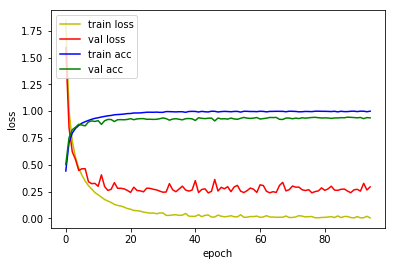

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2874 - acc: 0.9211
Loss: 0.28742159195901945 Accuracy: 0.92107993

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3377 - acc: 0.5890
Epoch 00001: val_loss improved from inf to 0.99263, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/001-0.9926.hdf5
36805/36805 [==============================] - 131s 4ms/sample - loss: 1.3378 - acc: 0.5890 - val_loss: 0.9926 - val_acc: 0.7011
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5813 - acc: 0.8249
Epoch 00002: val_loss improved from 0.99263 to 0.43572, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/002-0.4357.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5813 - acc: 0.8249 - val_loss: 0.4357 - val_acc: 0.8682
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9959
Epoch 00027: val_loss did not improve from 0.18901
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0198 - acc: 0.9958 - val_loss: 0.2497 - val_acc: 0.9327
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9891
Epoch 00028: val_loss did not improve from 0.18901
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0408 - acc: 0.9891 - val_loss: 0.2266 - val_acc: 0.9401
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9975
Epoch 00029: val_loss did not improve from 0.18901
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0144 - acc: 0.9974 - val_loss: 0.2092 - val_acc: 0.9474
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9934
Epoch 00030: val_loss did not improve from 0.18901
36805/36805 [===========

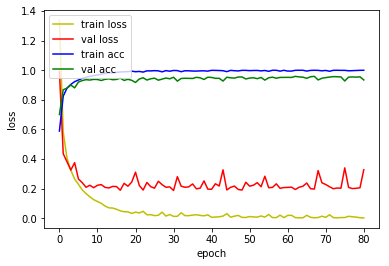

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2497 - acc: 0.9350
Loss: 0.24970976703665834 Accuracy: 0.9349948



In [14]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_135 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_27 (Dense)             (None, 16)                16384016  
Total params: 20,480,528
Trainable params: 18,432,400
Non-trainable params: 2,048,128
__________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.4996 - acc: 0.6077
Loss: 1.4996314696186182 Accuracy: 0.6076843

1D_CNN_5_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_145 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_146 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 1

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4636 - acc: 0.8702
Loss: 0.46364169726119236 Accuracy: 0.8701973

1D_CNN_8_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_163 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2497 - acc: 0.9350
Loss: 0.24970976703665834 Accuracy: 0.9349948


In [8]:
def build_1d_cnn_custom_conv_3_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_5 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9000 - acc: 0.1730
Epoch 00001: val_loss improved from inf to 2.49798, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_BN_checkpoint/001-2.4980.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 3.9000 - acc: 0.1730 - val_loss: 2.4980 - val_acc: 0.1989
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8132 - acc: 0.4486
Epoch 00002: val_loss did not improve from 2.49798
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.8133 - acc: 0.4485 - val_loss: 2.6663 - val_acc: 0.2278
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3221 - acc: 0.6023
Epoch 00003: val_loss did not improve from 2.49798
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.3221 - acc: 0.6023 - val_loss: 2.8679 -

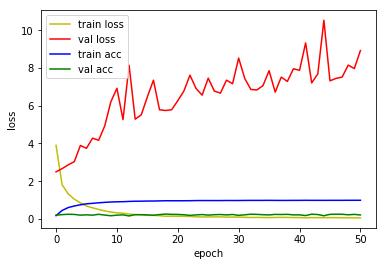

4815/4815 [==============================] - 2s 461us/sample - loss: 2.5164 - acc: 0.2008
Loss: 2.5164470192799318 Accuracy: 0.20083074

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2705 - acc: 0.2258
Epoch 00001: val_loss improved from inf to 3.98781, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_BN_checkpoint/001-3.9878.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 4.2705 - acc: 0.2258 - val_loss: 3.9878 - val_acc: 0.1889
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3535 - acc: 0.4574
Epoch 00002: val_loss improved from 3.98781 to 3.31208, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_BN_checkpoint/002-3.3121.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.3539 - acc: 0.4574 - val_loss: 3.3121 - val_acc: 0.2802
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

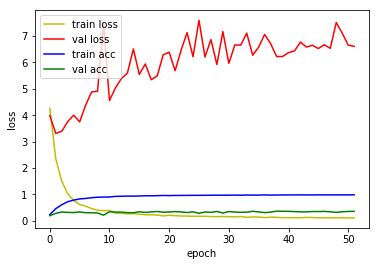

4815/4815 [==============================] - 4s 753us/sample - loss: 3.6442 - acc: 0.2658
Loss: 3.6442204505112312 Accuracy: 0.26583594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7131 - acc: 0.2895
Epoch 00001: val_loss improved from inf to 2.15602, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_BN_checkpoint/001-2.1560.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 2.7135 - acc: 0.2894 - val_loss: 2.1560 - val_acc: 0.2968
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7035 - acc: 0.4965
Epoch 00002: val_loss did not improve from 2.15602
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.7037 - acc: 0.4965 - val_loss: 2.3646 - val_acc: 0.3711
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2673 - acc: 0.6105
Epoch 00003: val_loss did not improve from 2.15602
36805/36805 [=========

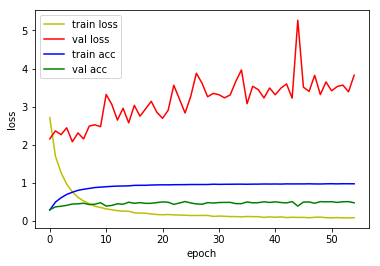

4815/4815 [==============================] - 4s 765us/sample - loss: 2.2421 - acc: 0.4129
Loss: 2.2420665784045544 Accuracy: 0.41287643

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3716 - acc: 0.3225
Epoch 00001: val_loss improved from inf to 1.79651, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/001-1.7965.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 2.3716 - acc: 0.3225 - val_loss: 1.7965 - val_acc: 0.4151
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6917 - acc: 0.4765
Epoch 00002: val_loss improved from 1.79651 to 1.56537, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/002-1.5654.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.6917 - acc: 0.4766 - val_loss: 1.5654 - val_acc: 0.5204
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1307 - acc: 0.9598
Epoch 00058: val_loss did not improve from 1.34654
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.1307 - acc: 0.9597 - val_loss: 1.6893 - val_acc: 0.6473
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9608
Epoch 00059: val_loss did not improve from 1.34654
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.1291 - acc: 0.9608 - val_loss: 1.9872 - val_acc: 0.6133

1D_CNN_4_conv_custom_conv_3_DO_BN Model


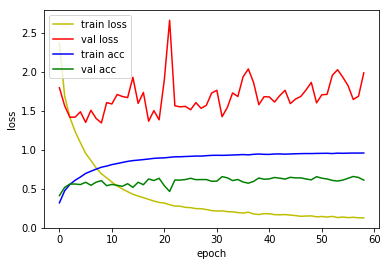

4815/4815 [==============================] - 4s 813us/sample - loss: 1.4538 - acc: 0.5907
Loss: 1.4538286903565547 Accuracy: 0.5906542

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3269 - acc: 0.3427
Epoch 00001: val_loss improved from inf to 1.64494, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/001-1.6449.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.3270 - acc: 0.3427 - val_loss: 1.6449 - val_acc: 0.4819
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6748 - acc: 0.4942
Epoch 00002: val_loss improved from 1.64494 to 1.43666, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/002-1.4367.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 1.6749 - acc: 0.4941 - val_loss: 1.4367 - val_acc: 0.5581
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1422 - acc: 0.9567
Epoch 00058: val_loss did not improve from 1.11912
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.1423 - acc: 0.9567 - val_loss: 1.4808 - val_acc: 0.6951

1D_CNN_5_conv_custom_conv_3_DO_BN Model


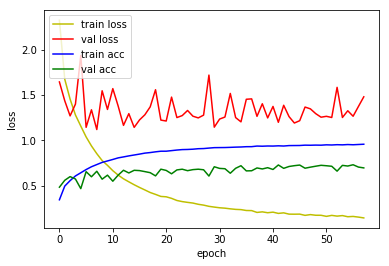

4815/4815 [==============================] - 4s 817us/sample - loss: 1.1818 - acc: 0.6598
Loss: 1.181750212874368 Accuracy: 0.6598131

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4011 - acc: 0.3088
Epoch 00001: val_loss improved from inf to 1.88323, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/001-1.8832.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.4010 - acc: 0.3088 - val_loss: 1.8832 - val_acc: 0.3725
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7512 - acc: 0.4635
Epoch 00002: val_loss improved from 1.88323 to 1.33033, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/002-1.3303.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.7512 - acc: 0.4635 - val_loss: 1.3303 - val_acc: 0.5849
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5066 - acc: 0.8406
Epoch 00027: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.5066 - acc: 0.8406 - val_loss: 0.9024 - val_acc: 0.7335
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4891 - acc: 0.8482
Epoch 00028: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.4895 - acc: 0.8481 - val_loss: 0.9296 - val_acc: 0.7174
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4808 - acc: 0.8486
Epoch 00029: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.4808 - acc: 0.8486 - val_loss: 1.0267 - val_acc: 0.7014
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4648 - acc: 0.8527
Epoch 00030: val_loss did not improve from 0.85137
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2784 - acc: 0.9095
Epoch 00057: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2784 - acc: 0.9095 - val_loss: 0.9512 - val_acc: 0.7438
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2680 - acc: 0.9143
Epoch 00058: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2681 - acc: 0.9143 - val_loss: 0.8632 - val_acc: 0.7668
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2711 - acc: 0.9121
Epoch 00059: val_loss did not improve from 0.85137
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2713 - acc: 0.9121 - val_loss: 0.9743 - val_acc: 0.7522
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2737 - acc: 0.9108
Epoch 00060: val_loss did not improve from 0.85137
36805/36805 [===========

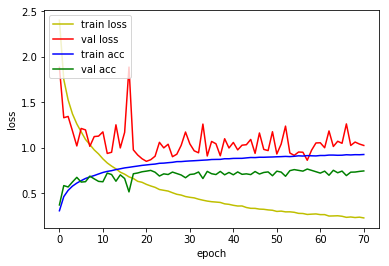

4815/4815 [==============================] - 4s 903us/sample - loss: 0.9955 - acc: 0.7275
Loss: 0.995461107538249 Accuracy: 0.7275182

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5022 - acc: 0.2765
Epoch 00001: val_loss improved from inf to 2.03086, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/001-2.0309.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.5022 - acc: 0.2765 - val_loss: 2.0309 - val_acc: 0.3343
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8127 - acc: 0.4419
Epoch 00002: val_loss improved from 2.03086 to 1.41563, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/002-1.4156.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.8127 - acc: 0.4419 - val_loss: 1.4156 - val_acc: 0.5604
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5875 - acc: 0.8234
Epoch 00026: val_loss did not improve from 0.72222
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5875 - acc: 0.8234 - val_loss: 1.0804 - val_acc: 0.6820
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5729 - acc: 0.8261
Epoch 00027: val_loss improved from 0.72222 to 0.68872, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/027-0.6887.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5729 - acc: 0.8261 - val_loss: 0.6887 - val_acc: 0.7976
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5586 - acc: 0.8288
Epoch 00028: val_loss did not improve from 0.68872
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5587 - acc: 0.8288 - val_loss: 0.7755 - val_acc: 0.7920
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3375 - acc: 0.8978
Epoch 00055: val_loss did not improve from 0.62603
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3375 - acc: 0.8978 - val_loss: 0.7986 - val_acc: 0.7722
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3329 - acc: 0.8979
Epoch 00056: val_loss did not improve from 0.62603
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3329 - acc: 0.8978 - val_loss: 0.7212 - val_acc: 0.8071
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3237 - acc: 0.9013
Epoch 00057: val_loss did not improve from 0.62603
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3237 - acc: 0.9013 - val_loss: 0.6447 - val_acc: 0.8199
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3173 - acc: 0.9036
Epoch 00058: val_loss did not improve from 0.62603
36805/36805 [===========

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9535
Epoch 00114: val_loss did not improve from 0.62577
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1516 - acc: 0.9535 - val_loss: 0.7262 - val_acc: 0.8169
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1509 - acc: 0.9539
Epoch 00115: val_loss did not improve from 0.62577
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1509 - acc: 0.9539 - val_loss: 0.8976 - val_acc: 0.7885
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9548
Epoch 00116: val_loss did not improve from 0.62577
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1514 - acc: 0.9548 - val_loss: 1.0416 - val_acc: 0.7710
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9495
Epoch 00117: val_loss did not improve from 0.62577
36805/36805 [=======

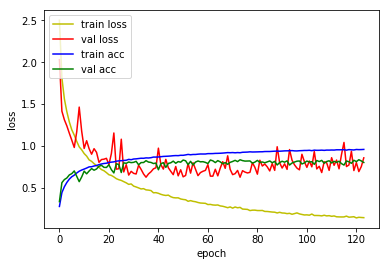

4815/4815 [==============================] - 5s 965us/sample - loss: 0.7792 - acc: 0.7931
Loss: 0.7792067927115927 Accuracy: 0.79314643

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5744 - acc: 0.2605
Epoch 00001: val_loss improved from inf to 1.80977, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/001-1.8098.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.5743 - acc: 0.2606 - val_loss: 1.8098 - val_acc: 0.4554
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7928 - acc: 0.4354
Epoch 00002: val_loss improved from 1.80977 to 1.26970, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/002-1.2697.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.7928 - acc: 0.4354 - val_loss: 1.2697 - val_acc: 0.6191
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3679 - acc: 0.8904
Epoch 00025: val_loss improved from 0.34737 to 0.33638, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/025-0.3364.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3678 - acc: 0.8904 - val_loss: 0.3364 - val_acc: 0.9096
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3551 - acc: 0.8936
Epoch 00026: val_loss did not improve from 0.33638
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3551 - acc: 0.8936 - val_loss: 0.3564 - val_acc: 0.8996
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3375 - acc: 0.9012
Epoch 00027: val_loss did not improve from 0.33638
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3376 - acc: 0.9012 - val_loss: 0.3381 - val_acc: 0.9001
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3295 - a

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0908 - acc: 0.9738
Epoch 00083: val_loss did not improve from 0.27259
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0908 - acc: 0.9738 - val_loss: 0.3723 - val_acc: 0.9080
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0902 - acc: 0.9727
Epoch 00084: val_loss did not improve from 0.27259
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0902 - acc: 0.9727 - val_loss: 0.3645 - val_acc: 0.9124
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0804 - acc: 0.9767
Epoch 00085: val_loss did not improve from 0.27259
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0804 - acc: 0.9767 - val_loss: 0.3569 - val_acc: 0.9164
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0805 - acc: 0.9764
Epoch 00086: val_loss did not improve from 0.27259
36805/36805 [===========

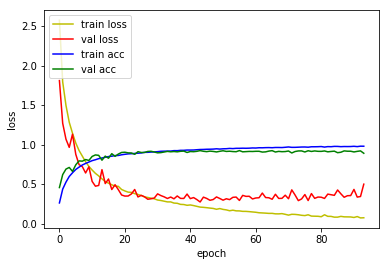

4815/4815 [==============================] - 5s 960us/sample - loss: 0.3463 - acc: 0.9049
Loss: 0.3462612187132038 Accuracy: 0.9048806

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1492 - acc: 0.3757
Epoch 00001: val_loss improved from inf to 1.39547, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/001-1.3955.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.1494 - acc: 0.3757 - val_loss: 1.3955 - val_acc: 0.6327
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3146 - acc: 0.5890
Epoch 00002: val_loss improved from 1.39547 to 0.83274, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/002-0.8327.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.3147 - acc: 0.5891 - val_loss: 0.8327 - val_acc: 0.7605
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1349 - acc: 0.9581
Epoch 00026: val_loss did not improve from 0.20330
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1349 - acc: 0.9581 - val_loss: 0.2280 - val_acc: 0.9317
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1294 - acc: 0.9599
Epoch 00027: val_loss did not improve from 0.20330
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1294 - acc: 0.9599 - val_loss: 0.2217 - val_acc: 0.9373
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1256 - acc: 0.9620
Epoch 00028: val_loss improved from 0.20330 to 0.20014, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_BN_checkpoint/028-0.2001.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1256 - acc: 0.9620 - val_loss: 0.2001 - val_acc: 0.9443
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9852
Epoch 00055: val_loss did not improve from 0.18355
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0509 - acc: 0.9851 - val_loss: 0.2478 - val_acc: 0.9371
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9886
Epoch 00056: val_loss did not improve from 0.18355
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0410 - acc: 0.9886 - val_loss: 0.2448 - val_acc: 0.9443
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9863
Epoch 00057: val_loss did not improve from 0.18355
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0469 - acc: 0.9863 - val_loss: 0.2167 - val_acc: 0.9504
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9906
Epoch 00058: val_loss did not improve from 0.18355
36805/36805 [===========

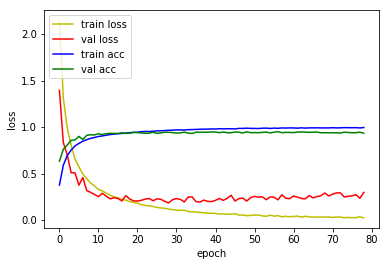

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2504 - acc: 0.9304
Loss: 0.25040157541307706 Accuracy: 0.93042576



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_9 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,528
Trainable params: 16,384,400
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.1818 - acc: 0.6598
Loss: 1.181750212874368 Accuracy: 0.6598131

1D_CNN_6_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_168 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_104 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_169 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_190 (MaxPoolin (None,

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3463 - acc: 0.9049
Loss: 0.3462612187132038 Accuracy: 0.9048806

1D_CNN_9_conv_custom_conv_3_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_17 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_82 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None